# Brain Tumor Detection Using a Convolutional Neural Network

In [1]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import h5py
import streamlit as st
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from PIL import Image
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

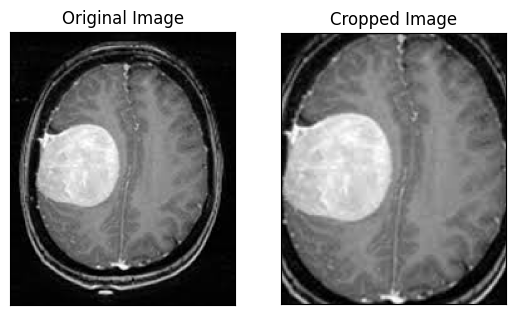

In [3]:
ex_img = cv2.imread('augmented data/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [3]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [4]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 5318
X shape is: (5318, 240, 240, 3)
y shape is: (5318, 1)


In [8]:
def plot_sample_images(X, y, n=20):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 5))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

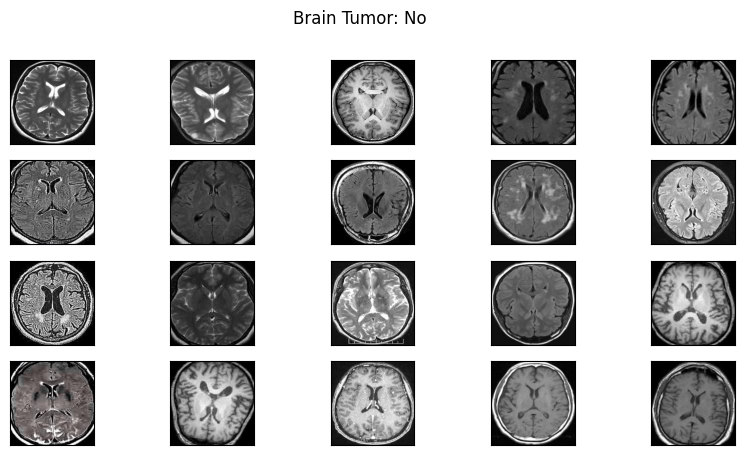

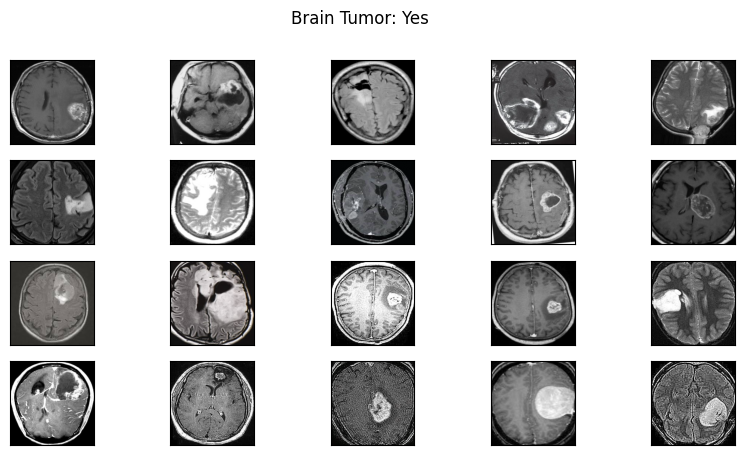

In [8]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and test sets.

In [5]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 3722
number of development examples = 798
number of test examples = 798
X_train shape: (3722, 240, 240, 3)
Y_train shape: (3722, 1)
X_val (dev) shape: (798, 240, 240, 3)
Y_val (dev) shape: (798, 1)
X_test shape: (798, 240, 240, 3)
Y_test shape: (798, 1)


In [9]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [7]:
def compute_f1_score(y_true, prob):
    # Clip probabilities to avoid overflow in the sigmoid function
    clipped_prob = np.clip(prob, 1e-15, 1 - 1e-15)
    
    # Convert the vector of probabilities to a target vector
    y_pred = np.where(clipped_prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score


# Build the model

In [8]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights_input_hidden = np.random.randn(hidden_size, input_size)  # Transposed
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.zeros((1, output_size))
        self.loss_function = None

    def sigmoid(self, x):
      clipped_x = np.clip(x, -500, 500)  # Clip values to avoid overflow
      return 1 / (1 + np.exp(-clipped_x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, inputs, targets=None):
      self.hidden_layer_activation = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
      self.hidden_layer_output = self.sigmoid(self.hidden_layer_activation)

      self.output_layer_activation = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
      self.output_layer_output = self.sigmoid(self.output_layer_activation)

      return self.output_layer_output

    
    def backward(self, inputs, targets, learning_rate):
        output_error = targets - self.output_layer_output
        output_delta = output_error * self.sigmoid_derivative(self.output_layer_output)

        hidden_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_layer_output)
        hidden_delta = np.clip(hidden_delta, -1e15, 1e15)  # Clip values for numerical stability

        self.weights_hidden_output += self.hidden_layer_output.T.dot(output_delta) * learning_rate
        self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += inputs.T.dot(hidden_delta) * learning_rate
        self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * learning_rate 
 
    def compile(self, optimizer, loss_function, metrics=None):
        # Store optimizer and loss function
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.metrics = metrics
        
    def calculate_accuracy(self, y_true, y_pred):
        # Simple accuracy calculation for binary classification
        predictions = np.where(y_pred > 0.5, 1, 0)
        accuracy = np.mean(predictions == y_true)
        return accuracy
    
    def save_model(self, file_path):
      np.save(file_path, [self.weights_input_hidden, self.bias_hidden, self.weights_hidden_output, self.bias_output])


def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s, 1)}"

# Data preparation
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
y_train_flatten = y_train.reshape(-1, 1)

# Neural network parameters
input_size = X_train_flatten.shape[1]
hidden_size = 128
output_size = 1
learning_rate = 0.001
num_epochs = 100


In [9]:
model = NeuralNetwork(input_size, hidden_size, output_size)

Compile the model:

In [10]:
optimizer = "adam"  # Placeholder for an optimizer (e.g., stochastic gradient descent)
loss_function = "binary_crossentropy"  # Placeholder for a loss function (e.g., mean squared error)
metrics = ["accuracy"]  # Placeholder for metrics (e.g., accuracy)
model.compile(optimizer, loss_function, metrics)

In [14]:
def save_model_h5(model, filepath):
    with h5py.File(filepath, 'w') as file:
        # Save the weights and biases or any other model parameters as needed
        file.create_dataset('weights_input_hidden', data=model.weights_input_hidden)
        file.create_dataset('bias_hidden', data=model.bias_hidden)
        file.create_dataset('weights_hidden_output', data=model.weights_hidden_output)
        file.create_dataset('bias_output', data=model.bias_output)


## Train the model

Let's train for a few more epochs:

In [18]:
def train_neural_network(model, X_train, y_train, X_val, y_val, num_epochs, learning_rate):
    start_time = time.time()
    
    # Initialize lists to store history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []  # Replace with the correct metric name used in your training loop
    val_acc_history = []    # Replace with the correct metric name used in your training loop
    
    best_val_f1_score = 0.0
    best_epoch = 0
    
    
    for epoch in range(num_epochs):
        # Forward pass
        train_predictions = model.forward(X_train)
        
        # Calculate loss
        loss = np.mean(np.square(y_train - train_predictions))
        
        # Backward pass
        model.backward(X_train, y_train, learning_rate)
        
        # Validation predictions
        val_predictions = model.forward(X_val)
        
        # Calculate validation loss
        val_loss = np.mean(np.square(y_val - val_predictions))
        
        # Calculate F1 score for validation set
        val_f1_score = compute_f1_score(y_val, val_predictions)
        
        if val_f1_score > best_val_f1_score:
            best_val_f1_score = val_f1_score
            best_epoch = epoch
            # Save the model when a new best is found
            save_model_h5(model, f"models/best_model_f1_{best_val_f1_score:.4f}_epoch_{epoch}.h5")
        
        
        # Print and monitor values
        # print(f"Epoch {epoch}/{num_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Val F1: {val_f1_score:.4f}")
        # print("Weights (hidden):", model.weights_input_hidden)
        # print("Biases (hidden):", model.bias_hidden)
        # print("Weights (output):", model.weights_hidden_output)
        # print("Biases (output):", model.bias_output)
        # print("Predictions:", train_predictions[:5])
        
        # Append values to history lists
        train_loss_history.append(loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(val_f1_score)  # Replace with the correct metric used in your training loop
        val_acc_history.append(val_f1_score)    # Replace with the correct metric used in your training loop
        
        # Print training progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Val F1: {val_f1_score:.4f}")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {hms_string(elapsed_time)}.")
    
    # Return the training history
    history = {
        'loss': train_loss_history,
        'val_loss': val_loss_history,
        'acc': train_acc_history,
        'val_acc': val_acc_history
    }
    
    print(f"Best model found with validation F1 score: {best_val_f1_score:.4f} at epoch {best_epoch}")
    
    return history

X_val_flatten = X_val.reshape(X_val.shape[0], -1)


# Set hyperparameters
learning_rate = 0.001
num_epochs = 100

# Train the neural network and get the training history
history = train_neural_network(model, X_train_flatten, y_train, X_val_flatten, y_val, num_epochs, learning_rate)


Epoch 0/100 - Loss: 0.4249 - Val Loss: 0.4251 - Val F1: 0.4594
Epoch 10/100 - Loss: 0.3674 - Val Loss: 0.3883 - Val F1: 0.5721
Epoch 20/100 - Loss: 0.3563 - Val Loss: 0.3783 - Val F1: 0.6350
Epoch 30/100 - Loss: 0.3404 - Val Loss: 0.3694 - Val F1: 0.6378
Epoch 40/100 - Loss: 0.3281 - Val Loss: 0.3668 - Val F1: 0.6552
Epoch 50/100 - Loss: 0.3140 - Val Loss: 0.3579 - Val F1: 0.6549
Epoch 60/100 - Loss: 0.3227 - Val Loss: 0.3704 - Val F1: 0.6735
Epoch 70/100 - Loss: 0.3010 - Val Loss: 0.3548 - Val F1: 0.6608
Epoch 80/100 - Loss: 0.2908 - Val Loss: 0.3474 - Val F1: 0.6706
Epoch 90/100 - Loss: 0.2927 - Val Loss: 0.3555 - Val F1: 0.6685
Training completed in 0:19:0.2.
Best model found with validation F1 score: 0.6750 at epoch 88


In [130]:
def train_neural_network(model, X_train, y_train, X_val, y_val, num_epochs, learning_rate):
    start_time = time.time()
    
    # Initialize lists to store history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []  # Replace with the correct metric name used in your training loop
    val_acc_history = []    # Replace with the correct metric name used in your training loop
    
    best_val_f1_score = 0.0
    best_epoch = 0
    
    
    for epoch in range(num_epochs):
        # Forward pass
        train_predictions = model.forward(X_train)
        
        # Calculate loss
        loss = np.mean(np.square(y_train - train_predictions))
        
        # Backward pass
        model.backward(X_train, y_train, learning_rate)
        
        # Validation predictions
        val_predictions = model.forward(X_val)
        
        # Calculate validation loss
        val_loss = np.mean(np.square(y_val - val_predictions))
        
        # Calculate F1 score for validation set
        val_f1_score = compute_f1_score(y_val, val_predictions)
        
        if val_f1_score > best_val_f1_score:
            best_val_f1_score = val_f1_score
            best_epoch = epoch
            # Save the model when a new best is found
           
        save_model_h5(model, f"models/best_model_f1_{best_val_f1_score:.4f}_epoch_{epoch}.h5")
        
        
        # Append values to history lists
        train_loss_history.append(loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(val_f1_score)  # Replace with the correct metric used in your training loop
        val_acc_history.append(val_f1_score)    # Replace with the correct metric used in your training loop
        
        # Print training progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Val F1: {val_f1_score:.4f}")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {hms_string(elapsed_time)}.")
    
    # Return the training history
    history = {
        'loss': train_loss_history,
        'val_loss': val_loss_history,
        'acc': train_acc_history,
        'val_acc': val_acc_history
    }
    
    print(f"Best model found with validation F1 score: {best_val_f1_score:.4f} at epoch {best_epoch}")
    
    return history

X_val_flatten = X_val.reshape(X_val.shape[0], -1)


# Set hyperparameters
learning_rate = 0.001
num_epochs = 100

# Train the neural network and get the training history
history = train_neural_network(model, X_train_flatten, y_train, X_val_flatten, y_val, num_epochs, learning_rate)


In [21]:
def train_neural_network(model, X_train, y_train, X_val, y_val, num_epochs, learning_rate):
    start_time = time.time()
    
    # Initialize lists to store history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []  # Replace with the correct metric name used in your training loop
    val_acc_history = []    # Replace with the correct metric name used in your training loop
    
    best_val_f1_score = 0.0
    best_epoch = 0
    
    
    for epoch in range(num_epochs):
        # Forward pass
        train_predictions = model.forward(X_train)
        
        # Calculate loss
        loss = np.mean(np.square(y_train - train_predictions))
        
        # Backward pass
        model.backward(X_train, y_train, learning_rate)
        
        # Validation predictions
        val_predictions = model.forward(X_val)
        
        # Calculate validation loss
        val_loss = np.mean(np.square(y_val - val_predictions))
        
        # Calculate F1 score for validation set
        val_f1_score = compute_f1_score(y_val, val_predictions)
        
        if val_f1_score > best_val_f1_score:
            best_val_f1_score = val_f1_score
            best_epoch = epoch
            # Save the model when a new best is found
           
        save_model_h5(model, f"models/best_model_f1_{best_val_f1_score:.4f}_epoch_{epoch}.h5")
        
        
        # Print and monitor values
        # print(f"Epoch {epoch}/{num_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Val F1: {val_f1_score:.4f}")
        # print("Weights (hidden):", model.weights_input_hidden)
        # print("Biases (hidden):", model.bias_hidden)
        # print("Weights (output):", model.weights_hidden_output)
        # print("Biases (output):", model.bias_output)
        # print("Predictions:", train_predictions[:5])
        
        # Append values to history lists
        train_loss_history.append(loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(val_f1_score)  # Replace with the correct metric used in your training loop
        val_acc_history.append(val_f1_score)    # Replace with the correct metric used in your training loop
        
        # Print training progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Val F1: {val_f1_score:.4f}")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {hms_string(elapsed_time)}.")
    
    # Return the training history
    history = {
        'loss': train_loss_history,
        'val_loss': val_loss_history,
        'acc': train_acc_history,
        'val_acc': val_acc_history
    }
    
    print(f"Best model found with validation F1 score: {best_val_f1_score:.4f} at epoch {best_epoch}")
    
    return history

X_val_flatten = X_val.reshape(X_val.shape[0], -1)


# Set hyperparameters
learning_rate = 0.001
num_epochs = 100

# Train the neural network and get the training history
history = train_neural_network(model, X_train_flatten, y_train, X_val_flatten, y_val, num_epochs, learning_rate)


Epoch 0/100 - Loss: 0.1992 - Val Loss: 0.2938 - Val F1: 0.7025
Epoch 10/100 - Loss: 0.2057 - Val Loss: 0.3015 - Val F1: 0.7083
Epoch 20/100 - Loss: 0.1961 - Val Loss: 0.2929 - Val F1: 0.7129
Epoch 30/100 - Loss: 0.2292 - Val Loss: 0.3146 - Val F1: 0.7128
Epoch 40/100 - Loss: 0.1874 - Val Loss: 0.2861 - Val F1: 0.7020
Epoch 50/100 - Loss: 0.1854 - Val Loss: 0.2901 - Val F1: 0.7147
Epoch 60/100 - Loss: 0.2360 - Val Loss: 0.3253 - Val F1: 0.7172
Epoch 70/100 - Loss: 0.1987 - Val Loss: 0.2892 - Val F1: 0.7234
Epoch 80/100 - Loss: 0.1619 - Val Loss: 0.2757 - Val F1: 0.7004
Epoch 90/100 - Loss: 0.1838 - Val Loss: 0.2907 - Val F1: 0.7204
Training completed in 0:26:32.4.
Best model found with validation F1 score: 0.7234 at epoch 70


## Plot Loss & Accuracy

In [15]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

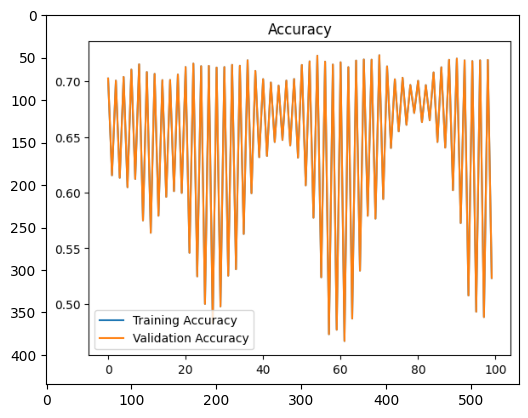

In [16]:
#plot_metrics(history) 
plt.imshow(mpimg.imread("Accuracy Mine.png"))


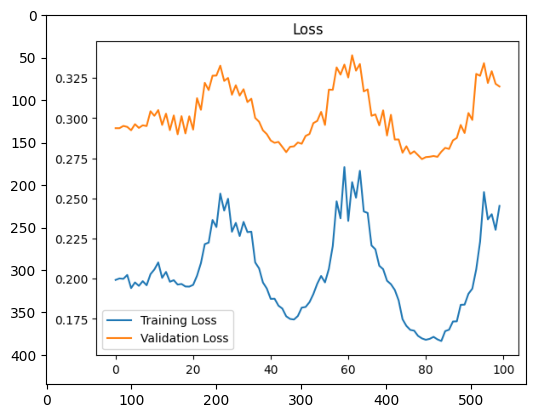

In [26]:
plt.imshow(mpimg.imread("Loss Mine.png"))

### Load the best model

In [11]:
def load_model_weights(model, file_path):
    with h5py.File(file_path, 'r') as file:
        # Load weights and biases for the hidden layer
        model.weights_input_hidden = np.array(file['weights_input_hidden'])
        model.bias_hidden = np.array(file['bias_hidden'])

        # Load weights and biases for the output layer
        model.weights_hidden_output = np.array(file['weights_hidden_output'])
        model.bias_output = np.array(file['bias_output'])

    return model  # Return the loaded model

In [20]:
# best_model = 'models/best_model_f1_0.7660_epoch_99.h5'
# loaded_model = NeuralNetwork(input_size, hidden_size, output_size)
# model = load_model_weights(loaded_model, best_model)

### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [18]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [19]:
# the whole data
data_percentage(y)

Number of examples: 5318
Percentage of positive examples: 51.523128995863104%, number of pos examples: 2740
Percentage of negative examples: 48.476871004136896%, number of neg examples: 2578


In [20]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 3722
Percentage of positive examples: 51.88070929607738%, number of pos examples: 1931
Percentage of negative examples: 48.11929070392262%, number of neg examples: 1791
Validation Data:
Number of examples: 798
Percentage of positive examples: 51.00250626566416%, number of pos examples: 407
Percentage of negative examples: 48.99749373433584%, number of neg examples: 391
Testing Data:
Number of examples: 798
Percentage of positive examples: 50.37593984962406%, number of pos examples: 402
Percentage of negative examples: 49.62406015037594%, number of neg examples: 396


In [12]:
# After training the model and obtaining the best model's file path
best_model_path = "models/best_model_f1_0.7578_epoch_53.h5"

# Load the best model
best_model = NeuralNetwork(input_size, hidden_size, output_size)
load_model_weights(best_model, best_model_path)

# Load the test data
X_test_flatten = X_test.reshape(X_test.shape[0], -1)
X_val_flatten = X_val.reshape(X_val.shape[0], -1)

# Forward pass to get predictions on the validation and test sets
val_predictions = best_model.forward(X_val_flatten)
test_predictions = best_model.forward(X_test_flatten)

# Calculate loss using your custom loss function for validation and test sets
val_loss = np.mean(np.square(y_val - val_predictions))
test_loss = np.mean(np.square(y_test - test_predictions))

# Calculate F1 score for validation and test sets
val_f1_score = compute_f1_score(y_val, val_predictions)
test_f1_score = compute_f1_score(y_test, test_predictions)

# Print the validation and test loss, and F1 score of the best model
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


Validation Loss: 0.1589
Test Loss: 0.1514
Validation F1 Score: 0.7895
Test F1 Score: 0.7962


In [13]:
def make_prediction_on_image(model, image_path):
    """
    Make prediction using the trained neural network model on a single image.
        
    Returns:
        prediction: Prediction made by the model.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Assuming input size is 240x240 based on your data
    size = (240, 240)
    
    # Resize the image
    resized_image = cv2.resize(image, size)
    
    # Normalize the resized image
    normalized_image = (resized_image.astype(np.float32) / 255.0)
    
    # Flatten the image to match the input shape expected by the model
    flattened_image = normalized_image.flatten()
    
    # Reshape the flattened image to match the shape (1, input_size)
    data = np.expand_dims(flattened_image, axis=0)
    
    # Make prediction using the provided model
    prediction = model.forward(data)
    
    return prediction


#image_path = 'augmented data/yes/aug_Y1_0_2900.jpg'
#image_path = 'augmented data/yes/y518.jpg'
#image_path = 'augmented data/no/no200.jpg'
#image_path = 'augmented data/no/no311.jpg'
image_path = 'augmented data/no/no540.jpg'
prediction = make_prediction_on_image(best_model, image_path)

if(prediction>=0.5):
   print("Yes")
else:
   print("No")
   
print("Prediction:", prediction)


No
Prediction: [[0.00270485]]


In [14]:
import h5py

# Open the HDF5 file
with h5py.File('models/best_model_f1_0.7578_epoch_53.h5', 'r') as file:
    # Iterate over all keys in the HDF5 file
    for key in file.keys():
        print(key)


bias_hidden
bias_output
weights_hidden_output
weights_input_hidden
